# Linear Programming 

In [1]:
# Tell Python to ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import modules and load the required datasets

In [2]:
# Import required libraries and packages
import pandas as pd
import numpy as np
import gurobipy as gp
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Import the given CSV files 
ROI_data = pd.read_csv('ROI_data.csv')
# Added index_col=0 to make month name as the index of dataframe
roi_mat = pd.read_csv('roi_mat.csv',index_col=0)
ROI_data


,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
1,Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [4]:
roi_mat

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
January,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
February,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
March,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
April,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
May,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9
June,4.0,3.2,2.7,3.4,3.4,3.0,4.5,2.10,3.8,4.1
July,3.9,3.6,2.0,4.4,3.9,3.7,4.3,1.80,4.0,3.8
August,4.2,3.3,2.8,4.2,2.0,3.7,3.6,1.50,4.4,4.3
September,4.1,2.8,2.5,4.2,2.9,3.7,2.8,2.50,4.0,3.4
October,3.0,3.0,3.1,4.6,3.1,3.3,3.2,2.30,2.5,3.2


Objective function to be optimized here is:

$$0.031*x_{1} + 0.049*x_{2} + 0.024*x_{3} + 0.039*x_{4} + x_{5} + 0.016*x_{6} + 0.046*x_{7} + 0.026*x_{8} + 0.033*x_{9} + 0.044*x_{10}$$

where, 

$$x_{1} = allocation\:of\:budget\:to\:Print$$
$$x_{2} = allocation\:of\:budget\:to\:TV$$
$$x_{3} = allocation\:of\:budget\:to\:SEO$$ 
$$x_{4} = allocation\:of\:budget\:to\:Adwords$$ 
$$x_{5} = allocation\:of\:budget\:to\:Facebook$$ 
$$x_{6} = allocation\:of\:budget\:to\:LinkedIn$$
$$x_{7} = allocation\:of\:budget\:to\:Instagram$$
$$x_{8} = allocation\:of\:budget\:to\:Snapchat$$ 
$$x_{9} = allocation\:of\:budget\:to\:Twitter$$
$$x_{10} = allocation\:of\:budget\:to\:Email$$

Constraints being used here are:

1. The amount invested in print and TV should be no more than the amount spent on Facebook and Email 
$$\implies x_{1} + x_{2}\leq x_{5}+x_{10}$$
2. The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords 
$$\implies x_{5} + x_{6}+x_{7}+x_{8}+x_{9}\geq 2(x_{3} + x_{4})$$
3. For each platform, the amount invested should be no more than \$3M.
$$\implies x_{i}\leq3\:for\:all\:x_{i}\:\in\:\{1,2,3,4,5,6,7,8,9,10\}$$
4. Total amount spent should be less than \$10M
$$\implies \sum_{i = 1}^{10} x_{i} \leq 10$$

In [5]:
#Construct a dictionary of marketing means having values from 0-9 so that we can use these variables 
#for constructing the contraint matrix without needing to hard code numbers.

#Take the column values except platform
mediums= list(ROI_data.columns)[1:] 
medium_dict={}
i=0
for word in mediums:
    medium_dict[word] = i
    i=i+1
medium_dict

{'Print': 0,
 'TV': 1,
 'SEO': 2,
 'AdWords': 3,
 'Facebook': 4,
 'LinkedIn': 5,
 'Instagram': 6,
 'Snapchat': 7,
 'Twitter': 8,
 'Email': 9}

In [6]:
# Construct the objective matrix and constraint matrix

# Consider first row of dataframe from column 1(drop platform column) for objective matrix
obj = np.array(ROI_data.iloc[0][1:])

# Left hand side of constraits.
A = np.zeros((len(obj)+3, len(obj))) #Initialize matrix with zeroes

# Each medium is budgeted for amount less than or equal to 3M. 
A[0:len(obj), 0:len(obj)] = np.identity(len(obj)) 

#Total budget is of 10M
A[len(obj), :] = 1 

#The amount invested in print and TV should be no more than the amount spent on Facebook and email
A[len(obj)+1, [medium_dict['Print'], medium_dict['TV']]] = 1 
A[len(obj)+1, [medium_dict['Facebook'], medium_dict['Email']]] = -1

#The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and 
#Twitter) should be at least twice of SEO and AdWords.

A[len(obj)+2, [medium_dict['SEO'], medium_dict['AdWords']]] = 2 
A[len(obj)+2, [medium_dict['Facebook'], medium_dict['LinkedIn'], medium_dict['Instagram'], medium_dict['Snapchat'], medium_dict['Twitter']]] = -1

#Right hand side of contraints

B = np.zeros(len(obj)+3)
B[0:len(obj)] = 3 #Each medium is budgeted for amount less than 3M. 
B[len(obj)] = 10 ##Total budget is of 10M

#Sign of contraints we have contructed.
sense = np.array(['<']*(len(obj)+3))

print("left side of contraints")
print(A)
print("right side of contraints")
print(B)

left side of contraints
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  0.  0. -1.  0.  0.  0.  0. -1.]
 [ 0.  0.  2.  2. -1. -1. -1. -1. -1.  0.]]
right side of contraints
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3. 10.  0.  0.]


In [7]:
# Optimize the problem using Gurobi
ojModel = gp.Model() # initialize an empty model

ojModX = ojModel.addMVar(len(obj)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon = ojModel.addMConstrs(A, ojModX, sense, B) # add the constraints to the model
ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
ojModel.Params.TimeLimit = 3600

ojModel.optimize() # solve the LP

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-26


The optimal ROI value is 0.45600000000000007

Marketing budget allocation across given mediums in millions 
TV           3.0
Instagram    3.0
Email        3.0
AdWords      1.0
Print        0.0
SEO          0.0
Facebook     0.0
LinkedIn     0.0
Snapchat     0.0
Twitter      0.0
dtype: float64


<AxesSubplot: >

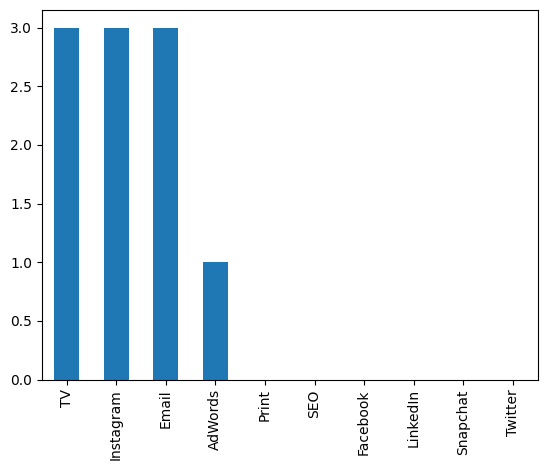

In [8]:
#Output of Gurobi
print('The optimal ROI value is '+ str(ojModel.objVal))

budget = list(ojModel.x)
budget_dict = {}
i=0
for word in mediums:
    budget_dict[word] = budget[i]
    i=i+1

print("\nMarketing budget allocation across given mediums in millions ")
print(pd.Series(budget_dict).sort_values(ascending=False))
pd.Series(budget_dict).sort_values(ascending=False).plot(kind = 'bar')

In [9]:
# Consider second row of dataframe from column 1(drop platform column) for objective matrix
obj2 = np.array(ROI_data.iloc[1][1:])

# We don't need to construct contraints again as only ROI data(objective matrix) has changed.
# Optimize the problem using Gurobi
ojModel2 = gp.Model() # initialize an empty model

ojModX2 = ojModel2.addMVar(len(obj2)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon2 = ojModel2.addMConstrs(A, ojModX2, sense, B) # add the constraints to the model
ojModel2.setMObjective(None,obj2,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel2.Params.OutputFlag = 0 # tell gurobi to shut up!!
ojModel2.Params.TimeLimit = 3600

ojModel2.optimize() # solve the LP

The optimal ROI value is 0.45600000000000007

Marketing budget allocation across given mediums in millions 
Print        3.0
Facebook     3.0
LinkedIn     3.0
AdWords      1.0
TV           0.0
SEO          0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
Email        0.0
dtype: float64


<AxesSubplot: >

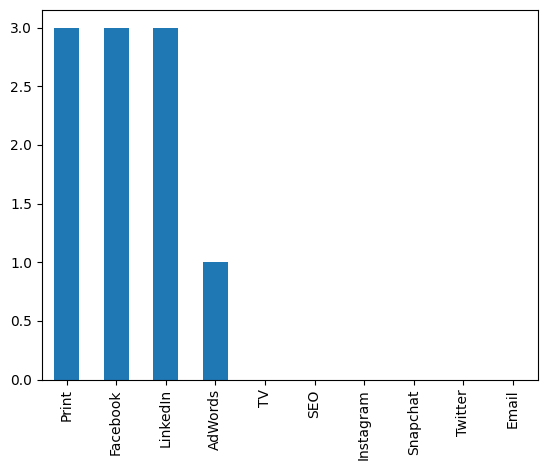

In [10]:
#Output of Gurobi
print('The optimal ROI value is '+ str(ojModel2.objVal))

budget2 = list(ojModel2.x)
budget_dict2 = {}
i=0
for word in mediums:
    budget_dict2[word] = budget2[i]
    i=i+1

print("\nMarketing budget allocation across given mediums in millions ")
print(pd.Series(budget_dict2).sort_values(ascending=False))
pd.Series(budget_dict2).sort_values(ascending=False).plot(kind = 'bar')

The allocations are not the same. The difference in the objective function for the first and second ROI values is 0. You can assume that any of the two ROI data is correct, this is because the constraints involved are non-binding, so that means that they are not sensitive to changes in the coefficients of the objective value function within a given range. The boss' third constraint makes sense because we want to distribute our assets among all the outlets. This means that if any one marketing medium fails, we would still gain profits from the others

In [11]:
#First ROI is correct and second allocation is used
ojModel.objVal - obj@ojModel2.x

0.20400000000000007

In [12]:
#Second ROI is correct and first allocation is used
ojModel2.objVal-obj2@ojModel.x

0.19200000000000006

In [13]:
# Remove the 3rd contraint to see if it's useful

# Left hand side of constraits.
A = np.zeros((3, len(obj))) #Initialize matrix with zeroes



#Total budget is of 10M
A[0, :] = 1 

#The amount invested in print and TV should be no more than the amount spent on Facebook and email
A[1, [medium_dict['Print'], medium_dict['TV']]] = 1 
A[1, [medium_dict['Facebook'], medium_dict['Email']]] = -1

#The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and 
#Twitter) should be at least twice of SEO and AdWords.

A[2, [medium_dict['SEO'], medium_dict['AdWords']]] = 2 
A[2, [medium_dict['Facebook'], medium_dict['LinkedIn'], medium_dict['Instagram'], medium_dict['Snapchat'], medium_dict['Twitter']]] = -1

#Right hand side of contraints

B = np.zeros(3)
B[0] = 10 ##Total budget is of 10M

#Sign of contraints we have contructed.
sense = np.array(['<']*3)


In [14]:
#Run the new model on ROI data 1
#Optimize the problem using Gurobi
ojModel3 = gp.Model() # initialize an empty model

ojModX3 = ojModel3.addMVar(len(obj)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon3 = ojModel3.addMConstrs(A, ojModX3, sense, B) # add the constraints to the model
ojModel3.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel3.Params.OutputFlag = 0 # tell gurobi to shut up!!
ojModel3.Params.TimeLimit = 3600

ojModel3.optimize() # solve the LP

#Run the new model on ROI data 2
#Optimize the problem using Gurobi
ojModel4 = gp.Model() # initialize an empty model

ojModX4 = ojModel4.addMVar(len(obj2)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon4 = ojModel4.addMConstrs(A, ojModX4, sense, B) # add the constraints to the model
ojModel4.setMObjective(None,obj2,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel4.Params.OutputFlag = 0 # tell gurobi to shut up!!
ojModel4.Params.TimeLimit = 3600

ojModel4.optimize() # solve the LP

The optimal ROI value is 0.46499999999999997

Marketing budget allocation across given mediums in millions 
TV           5.0
Email        5.0
Print        0.0
SEO          0.0
AdWords      0.0
Facebook     0.0
LinkedIn     0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
dtype: float64


<AxesSubplot: >

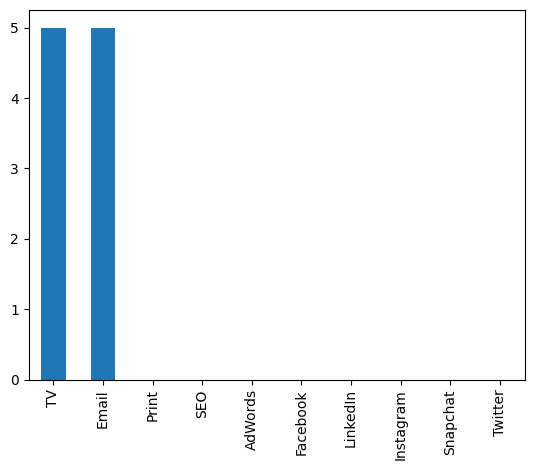

In [15]:
# Results of 2 new models
print('The optimal ROI value is '+ str(ojModel3.objVal))

budget3 = list(ojModel3.x)
budget_dict3 = {}
i=0
for word in mediums:
    budget_dict3[word] = budget3[i]
    i=i+1

print("\nMarketing budget allocation across given mediums in millions ")
print(pd.Series(budget_dict3).sort_values(ascending=False))
pd.Series(budget_dict3).sort_values(ascending=False).plot(kind = 'bar')





The optimal ROI value is 0.46499999999999997

Marketing budget allocation across given mediums in millions 
Print        5.0
Facebook     5.0
TV           0.0
SEO          0.0
AdWords      0.0
LinkedIn     0.0
Instagram    0.0
Snapchat     0.0
Twitter      0.0
Email        0.0
dtype: float64


<AxesSubplot: >

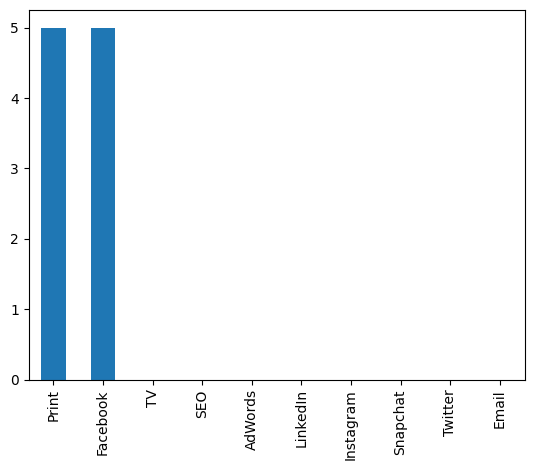

In [16]:
print('\nThe optimal ROI value is '+ str(ojModel4.objVal))

budget4 = list(ojModel4.x)
budget_dict4 = {}
i=0
for word in mediums:
    budget_dict4[word] = budget4[i]
    i=i+1

print("\nMarketing budget allocation across given mediums in millions ")
print(pd.Series(budget_dict4).sort_values(ascending=False))
pd.Series(budget_dict4).sort_values(ascending=False).plot(kind = 'bar')

Maximum profit returned is more without the constraint.  465000.0  USD

This is more than the ROI gained with the third constraint  456000.0  and  456000.0  by  9000.0  USD 
  
Summary : 

Profit is maximised without the constraint. However, As we can see the budget allocation for media spends is split in only in   two media. Adding a constraint maybe a method to avoid distributing budget in only two channels.

No, the allocations are not the same. The difference in the objective function for the first and second ROI values is 0. You can assume that any of the two ROI data is correct, this is because the constraints involved are non-binding, so that means that they are not sensitive to changes in the coefficients of the objective value function within a given range. The boss' third constraint makes sense because we want to distribute our assets among all the outlets. This means that if any one marketing medium fails, we would still gain profits from the others

In [17]:
# how our optimal allocation would change 
#based on changes in the ROI data

# We have 13 constraints hence we will get 13 values
print([con.Pi for con in ojModCon])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006999999999999999, 0.0, 0.0, 0.015, 0.039, 0.010000000000000002, 0.0]


Here, equaltion 7,10,11,12 have non zero values. Hence, these equations are binding constraints. Remaining constraints are non-binding constraints.


In [18]:
#By how much could each advertising medium’s ROI increase or decrease and 
#still result in the same optimal allocation you found in step (3)

print("The lowest values of variables are given below")
print(ojModX.SAObjLow)
print("The highest values of variables are given below")
print(ojModX.SAObjUp)

The lowest values of variables are given below
[ -inf 0.039  -inf 0.033  -inf  -inf 0.039  -inf  -inf 0.029]
The highest values of variables are given below
[0.049 0.062 0.039 0.046 0.029 0.039   inf 0.039 0.039   inf]


In [19]:
# create an Empty DataFrame object
df = pd.DataFrame()

df["platform"]=mediums
df["Minimum"]=ojModX.SAObjLow
df["Maximum"]=ojModX.SAObjUp
df["current value"]=obj
#The amount by which we can increase the ROI from the current value= Maximum-current
df["Allowed increase"]=df["Maximum"]-df["current value"]
#The amount by which we can decrease the ROI from the current value= current-Minimum
df["Allowed decrease"]=df["current value"]-df["Minimum"]

#Let's replace -inf with 0 and +inf with 0.1 to interpret our results in the better way.

df["Minimum"]=df["Minimum"].replace(float('-inf'), 0)
df["Maximum"]=df["Maximum"].replace(float('-inf'), 0)
df["Minimum"]=df["Minimum"].replace(float('inf'), 0.1)
df["Maximum"]=df["Maximum"].replace(float('inf'), 0.1)
df["Allowed increase"]=df["Allowed increase"].replace(float('-inf'), 0)
df["Allowed decrease"]=df["Allowed decrease"].replace(float('-inf'), 0)
df["Allowed increase"]=df["Allowed increase"].replace(float('inf'), 0.1)
df["Allowed decrease"]=df["Allowed decrease"].replace(float('inf'), 0.1)
df=df.set_index('platform')
df

,Minimum,Maximum,current value,Allowed increase,Allowed decrease
platform,,,,,
Print,0.000,0.049,0.031,0.018,0.100
TV,0.039,0.062,0.049,0.013,0.010
SEO,0.000,0.039,0.024,0.015,0.100
AdWords,0.033,0.046,0.039,0.007,0.006
Facebook,0.000,0.029,0.016,0.013,0.100
LinkedIn,0.000,0.039,0.024,0.015,0.100
Instagram,0.039,0.100,0.046,0.100,0.007
Snapchat,0.000,0.039,0.026,0.013,0.100
Twitter,0.000,0.039,0.033,0.006,0.100


In [20]:
# with 1st ROI
# Inital condition
obj3 = np.array(ROI_data.iloc[0][1:])
budget = 10

# Consider first row of dataframe from column 1(drop platform column) for objective matrix
obj = np.array(ROI_data.iloc[0][1:])

# Left hand side of constraits.
A = np.zeros((len(obj)+3, len(obj))) #Initialize matrix with zeroes

# Each medium is budgeted for amount less than or equal to 3M. 
A[0:len(obj), 0:len(obj)] = np.identity(len(obj)) 

#Total budget is of 10M
A[len(obj), :] = 1 

#The amount invested in print and TV should be no more than the amount spent on Facebook and email
A[len(obj)+1, [medium_dict['Print'], medium_dict['TV']]] = 1 
A[len(obj)+1, [medium_dict['Facebook'], medium_dict['Email']]] = -1

#The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and 
#Twitter) should be at least twice of SEO and AdWords.

A[len(obj)+2, [medium_dict['SEO'], medium_dict['AdWords']]] = 2 
A[len(obj)+2, [medium_dict['Facebook'], medium_dict['LinkedIn'], medium_dict['Instagram'], medium_dict['Snapchat'], medium_dict['Twitter']]] = -1



#Sign of contraints we have contructed.
sense = np.array(['<']*(len(obj)+3))

value=[]
monthly_allocation = {}
for i in roi_mat.index:
    
    # Right hand side
    B = np.zeros(len(obj3)+3)
    B[:len(obj3)] = 3
    B[len(obj3)] = budget

 

    # Use gurobi to optimize the solution
    AdvMod4 = gp.Model()
    Adv_x4 = AdvMod4.addMVar(len(obj3)) 
    AdvModCon4 = AdvMod4.addMConstrs(A, Adv_x4, sense, B)
    AdvMod4.setMObjective(None,obj3,0,sense=gp.GRB.MAXIMIZE) 
    AdvMod4.Params.OutputFlag = 0
    AdvMod4.optimize()
    
    profit = Adv_x4.x @ np.array(roi_mat.loc[i][0:]) / 100
    budget += profit*0.5
    value.append(AdvMod4.objVal)
    monthly_allocation[i] = Adv_x4.x

first_ROI_monthly = pd.DataFrame(monthly_allocation).T
first_ROI_monthly.set_axis(mediums, axis=1, inplace=True)
first_ROI_monthly['Total'] = first_ROI_monthly.sum(axis = 1)
first_ROI_monthly['Optimal ROI value']=value
first_ROI_monthly

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Total,Optimal ROI value
January,0.0,3.0,0.0,1.000000,0.0,0.0,3.0,0.0,0.000000,3.0,10.000000,0.456000
February,0.0,3.0,0.0,1.180000,0.0,0.0,3.0,0.0,0.000000,3.0,10.180000,0.463020
March,0.0,3.0,0.0,1.353920,0.0,0.0,3.0,0.0,0.000000,3.0,10.353920,0.469803
April,0.0,3.0,0.0,1.505381,0.0,0.0,3.0,0.0,0.010763,3.0,10.516144,0.476065
May,0.0,3.0,0.0,1.564986,0.0,0.0,3.0,0.0,0.129971,3.0,10.694957,0.482323
June,0.0,3.0,0.0,1.629829,0.0,0.0,3.0,0.0,0.259657,3.0,10.889486,0.489132
July,0.0,3.0,0.0,1.699709,0.0,0.0,3.0,0.0,0.399418,3.0,11.099126,0.496469
August,0.0,3.0,0.0,1.773336,0.0,0.0,3.0,0.0,0.546672,3.0,11.320008,0.504200
September,0.0,3.0,0.0,1.845758,0.0,0.0,3.0,0.0,0.691517,3.0,11.537275,0.511805
October,0.0,3.0,0.0,1.908289,0.0,0.0,3.0,0.0,0.816578,3.0,11.724866,0.518370


In [21]:
# Question 7 - with 1st ROI
# Inital condition
obj3 = np.array(ROI_data.iloc[1][1:])
budget = 10

# Consider first row of dataframe from column 1(drop platform column) for objective matrix
obj = np.array(ROI_data.iloc[0][1:])

# Left hand side of constraits.
A = np.zeros((len(obj)+3, len(obj))) #Initialize matrix with zeroes

# Each medium is budgeted for amount less than or equal to 3M. 
A[0:len(obj), 0:len(obj)] = np.identity(len(obj)) 

#Total budget is of 10M
A[len(obj), :] = 1 

#The amount invested in print and TV should be no more than the amount spent on Facebook and email
A[len(obj)+1, [medium_dict['Print'], medium_dict['TV']]] = 1 
A[len(obj)+1, [medium_dict['Facebook'], medium_dict['Email']]] = -1

#The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and 
#Twitter) should be at least twice of SEO and AdWords.

A[len(obj)+2, [medium_dict['SEO'], medium_dict['AdWords']]] = 2 
A[len(obj)+2, [medium_dict['Facebook'], medium_dict['LinkedIn'], medium_dict['Instagram'], medium_dict['Snapchat'], medium_dict['Twitter']]] = -1



#Sign of contraints we have contructed.
sense = np.array(['<']*(len(obj)+3))

value=[]
monthly_allocation = {}
for i in roi_mat.index:
    
    # Right hand side
    B = np.zeros(len(obj3)+3)
    B[:len(obj3)] = 3
    B[len(obj3)] = budget

 

    # Use gurobi to optimize the solution
    AdvMod4 = gp.Model()
    Adv_x4 = AdvMod4.addMVar(len(obj3)) 
    AdvModCon4 = AdvMod4.addMConstrs(A, Adv_x4, sense, B)
    AdvMod4.setMObjective(None,obj3,0,sense=gp.GRB.MAXIMIZE) 
    AdvMod4.Params.OutputFlag = 0
    AdvMod4.optimize()
    
    profit = Adv_x4.x @ np.array(roi_mat.loc[i][0:]) / 100
    budget += profit*0.5
    value.append(AdvMod4.objVal)
    monthly_allocation[i] = Adv_x4.x

first_ROI_monthly = pd.DataFrame(monthly_allocation).T
first_ROI_monthly.set_axis(mediums, axis=1, inplace=True)
first_ROI_monthly['Total'] = first_ROI_monthly.sum(axis = 1)
first_ROI_monthly['Optimal ROI value']=value
first_ROI_monthly

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email,Total,Optimal ROI value
January,3.0,0.0,0.0,1.000000,3.0,3.0,0.0,0.0,0.000000,0.0,10.000000,0.456000
February,3.0,0.0,0.0,1.177000,3.0,3.0,0.0,0.0,0.000000,0.0,10.177000,0.462903
March,3.0,0.0,0.0,1.371863,3.0,3.0,0.0,0.0,0.000000,0.0,10.371863,0.470503
April,3.0,0.0,0.0,1.547928,3.0,3.0,0.0,0.0,0.000000,0.0,10.547928,0.477369
May,3.0,0.0,0.0,1.731983,3.0,3.0,0.0,0.0,0.000000,0.0,10.731983,0.484547
June,3.0,0.0,0.0,1.894927,3.0,3.0,0.0,0.0,0.000000,0.0,10.894927,0.490902
July,3.0,0.0,0.0,2.083140,3.0,3.0,0.0,0.0,0.000000,0.0,11.083140,0.498242
August,3.0,0.0,0.0,2.301469,3.0,3.0,0.0,0.0,0.000000,0.0,11.301469,0.506757
September,3.0,0.0,0.0,2.498300,3.0,3.0,0.0,0.0,0.000000,0.0,11.498300,0.514434
October,3.0,0.0,0.0,2.711265,3.0,3.0,0.0,0.0,0.000000,0.0,11.711265,0.522739


A stable budget is defined as a monthly allocation such that for each platform the monthly 
change in spend is no more than $1M. Is the allocation stable? 

In [22]:
first_ROI_monthly=first_ROI_monthly.drop(columns='Total')
first_ROI_monthly=first_ROI_monthly.drop(columns='Optimal ROI value')
first_ROI_monthly.diff()

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
February,0.0,0.0,0.0,0.177000,0.0,0.0,0.0,0.0,0.000000,0.0
March,0.0,0.0,0.0,0.194863,0.0,0.0,0.0,0.0,0.000000,0.0
April,0.0,0.0,0.0,0.176065,0.0,0.0,0.0,0.0,0.000000,0.0
May,0.0,0.0,0.0,0.184054,0.0,0.0,0.0,0.0,0.000000,0.0
June,0.0,0.0,0.0,0.162944,0.0,0.0,0.0,0.0,0.000000,0.0
July,0.0,0.0,0.0,0.188214,0.0,0.0,0.0,0.0,0.000000,0.0
August,0.0,0.0,0.0,0.218329,0.0,0.0,0.0,0.0,0.000000,0.0
September,0.0,0.0,0.0,0.196831,0.0,0.0,0.0,0.0,0.000000,0.0
October,0.0,0.0,0.0,0.212964,0.0,0.0,0.0,0.0,0.000000,0.0


From the table we can see that for each platform the monthly change in spend is no more than $1M. Hence, allocation we found is stable.